# Process RoMEO Policies

Uses some methods and code from [`01.romeo.ipynb`](https://github.com/asapbio/publisher-agreements/blob/8adacf6b1020aa82ab7b5d4c9e02af516e5f3779/01.romeo.ipynb) in `asapbio/publisher-agreements`.

In [1]:
import json
import pathlib
from urllib.request import urlretrieve

import lxml.etree
import pandas
import networkx

## RoMEO Downloads

See http://www.sherpa.ac.uk/downloads/. Files are not downloaded if they exist. Hence to redownload RoMEO data, delete the files in `downloads`.

In [2]:
from secrets import romeo_api_key

In [3]:
files = [
    ('journal-title-issns', 'tsv'),
    ('journal-titles', 'tsv'),
    ('policies-summary', 'tsv'),
    ('policies-summary', 'xml'),
]
for name, extension in files:
    url = f'http://www.sherpa.ac.uk/downloads/{name}/{romeo_api_key}/{extension}/'
    path = pathlib.Path(f'downloads/{name}.{extension}')
    if path.is_file():
        continue
    path, headers = urlretrieve(url, path)
    timestamp = headers.get('Date')
    print(f'Downloaded {path} on {timestamp}')

In [4]:
path = pathlib.Path('downloads/policies-full.xml')
url = f'http://www.sherpa.ac.uk/romeo/api29.php?all=yes&ak={romeo_api_key}'
if not path.is_file():
    path, headers = urlretrieve(url, path)
    headers.get('Date')

## Construct ontology

In [5]:
graph = networkx.DiGraph(
    name='SHERPA RoMEO',
    license='CC BY-NC-SA 2.5',
    homepage='http://www.sherpa.ac.uk/romeo/index.php',
)

In [6]:
policy_summary_df = pandas.read_table('downloads/policies-summary.tsv')
policy_summary_df = policy_summary_df.sort_values('RoMEO Record ID')
policy_summary_df.head(2)

,RoMEO Record ID,Publisher,Policy Heading,Country,RoMEO colour,Published Permission,Published Restrictions,Published Max embargo,Accepted Permission,Accepted Restrictions,Accepted Max embargo,Submitted Permission,Submitted Restrictions,Submitted Max embargo,Open Access Publishing,Record Status,Updated
23,2,Academy of Management,[Default policy],US,green,restricted,False,NaN,can,False,NaN,can,False,NaN,NaN,public,2017-06-08
117,3,American Association for the Advancement of Sc...,[Default policy],US,green,cannot,False,NaN,can,False,NaN,can,False,NaN,NaN,public,2016-04-22


In [7]:
def format_romeo_id(number):
    if number is None or pandas.isna(number):
        return None
    return f'romeo_{number}'

In [8]:
# Create policy nodes
policies = json.loads(policy_summary_df.to_json(orient='records'))
for policy in policies:
    record_id = format_romeo_id(policy['RoMEO Record ID'])
    graph.add_node(record_id, **policy)

len(graph)

2976

In [9]:
# Create policy (parent) relationships
tree = lxml.etree.parse('downloads/policies-full.xml')
policies = tree.findall('publishers/publisher')
policies.sort(key=lambda x: int(x.get('id')))
for policy in policies:
    policy_id = format_romeo_id(policy.get('id'))
    parent_id = format_romeo_id(policy.get('parentid'))
    if not parent_id:
        continue
    graph.add_edge(policy_id, parent_id)

assert networkx.is_directed_acyclic_graph(graph)
graph.number_of_edges()

484

In [10]:
# # Print a single policy
# policy = policies[0]
# print(lxml.etree.tostring(policy, encoding=str))

In [11]:
# for child, parent in graph.edges():
#     child_data = graph.node[child]
#     parent_data = graph.node[parent]

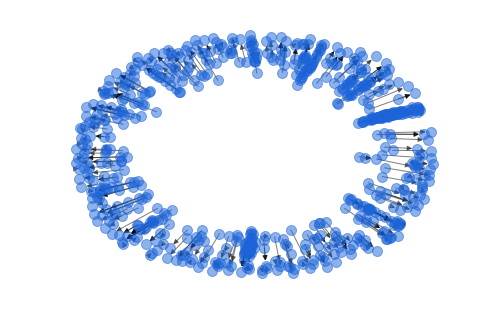

In [12]:
# Draw the policy graph (without journal nodes)
%matplotlib inline
connected_nodes = [node for node, degree in graph.degree(graph) if degree > 0]
len(connected_nodes)
connected = graph.subgraph(connected_nodes)
# https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx
networkx.draw(connected, alpha=0.5, node_size=100, node_color='#1c64d8')

In [13]:
with open('downloads/journal-title-issns.tsv', encoding='utf-8', errors='ignore') as read_file:
    journal_df = pandas.read_table(read_file)
journal_df = journal_df.sort_values(['RoMEO Record ID', 'Journal Title'])
journal_df.head(4)

,Journal Title,ISSN,ESSN,RoMEO Record ID,Updated
75,Academy of Management Discoveries,NaN,2168-1007,2,2017-06-08
76,Academy of Management Executive,1079-5545,NaN,2,2017-06-08
77,Academy of Management Journal,0001-4273,NaN,2,2017-06-08
78,Academy of Management Learning and Education,1537-260X,1944-9585,2,2017-06-08


In [14]:
# Create journal to policy relationships
# use to_json rather than to_dict to convert NaN to None
journals = json.loads(journal_df.to_json(orient='records'))
for journal in journals:
    journal_title = journal['Journal Title']
    graph.add_node(journal_title, **journal)
    parent = format_romeo_id(journal['RoMEO Record ID'])
    graph.add_edge(journal_title, parent)
graph.number_of_nodes(), graph.number_of_edges()

(32653, 30161)

In [15]:
# Export as node link data JSON
# https://networkx.github.io/documentation/stable/reference/readwrite/generated/networkx.readwrite.json_graph.node_link_data.html#networkx.readwrite.json_graph.node_link_data
node_link_data = networkx.node_link_data(graph)
with open('data/ontology.json', 'w') as write_file:
    json.dump(node_link_data, write_file, indent=2)